In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import os
from scipy.io import loadmat
from dpc import DPClustering

### Synthetic datasets from [github - mlyizhang](https://github.com/mlyizhang/Clustering-Datasets/tree/master/synthetic)

Number of elements in the original dataset:  788


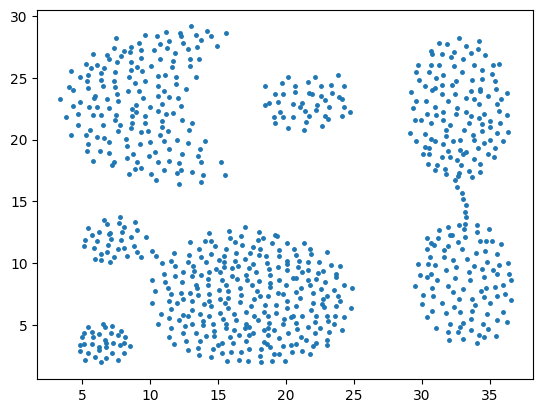

In [3]:
#Synthetic datasets
dataset_name = 'Aggregation'  #@param ["Compound", "Agreggation", "Spiral", "Flame", "R15", "2circles_noise", "banana", "2spiral", "Jain", "zelink1"]

mat = loadmat(r"C:/Users/gbs77/Desktop/Estudo/Investigação/DPC_worklab/datasets/{}.mat".format(dataset_name))
matrix_og = mat["data"]
print('Number of elements in the original dataset: ', len( matrix_og))

plt.plot(matrix_og[:,0],matrix_og[:,1],'.',markersize=5)
plt.show()

### Kernel Density Estimation (KDE)

Generate dataset with the same shape of the original dataset but different number of elements

In [4]:
from sklearn.neighbors import KernelDensity

def expand_with_kde_keep_original(X, n_new, bandwidth=1.0, random_state=None):
    """
    Returns an array with X plus (factor-1)*len(X) new points
    sampled from a global KDE fit to X.
    """
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde.fit(X)
    
    X_new = kde.sample(n_new, random_state=random_state)
    
    return X_new

### Sanity Check/Parameters Adjustments

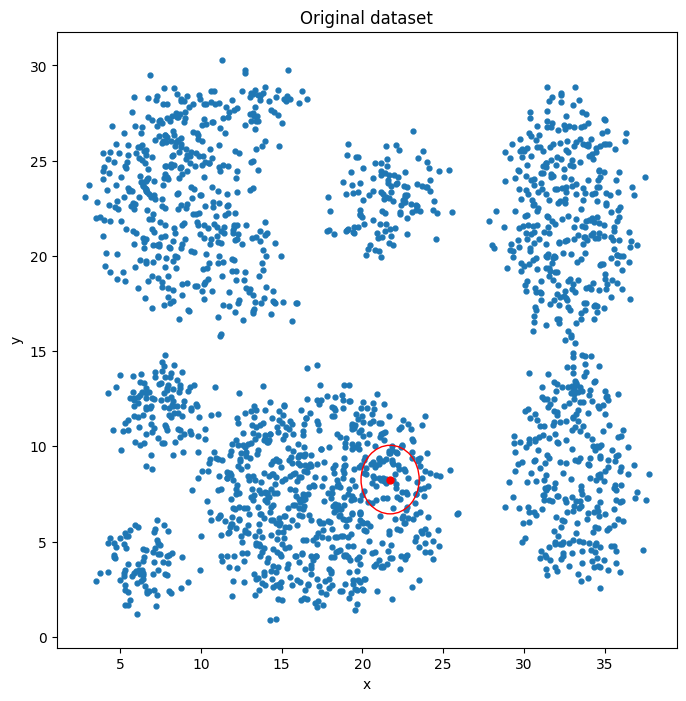

densities time: 0.05057780000788625
4.1771628755082054e-05 0.1528078532923175
precision time: 0.0002796000044327229
neighbors time: 0.028424800009815954
clustering time: 0.0042609999945852906
roles time: 0.023174899994046427


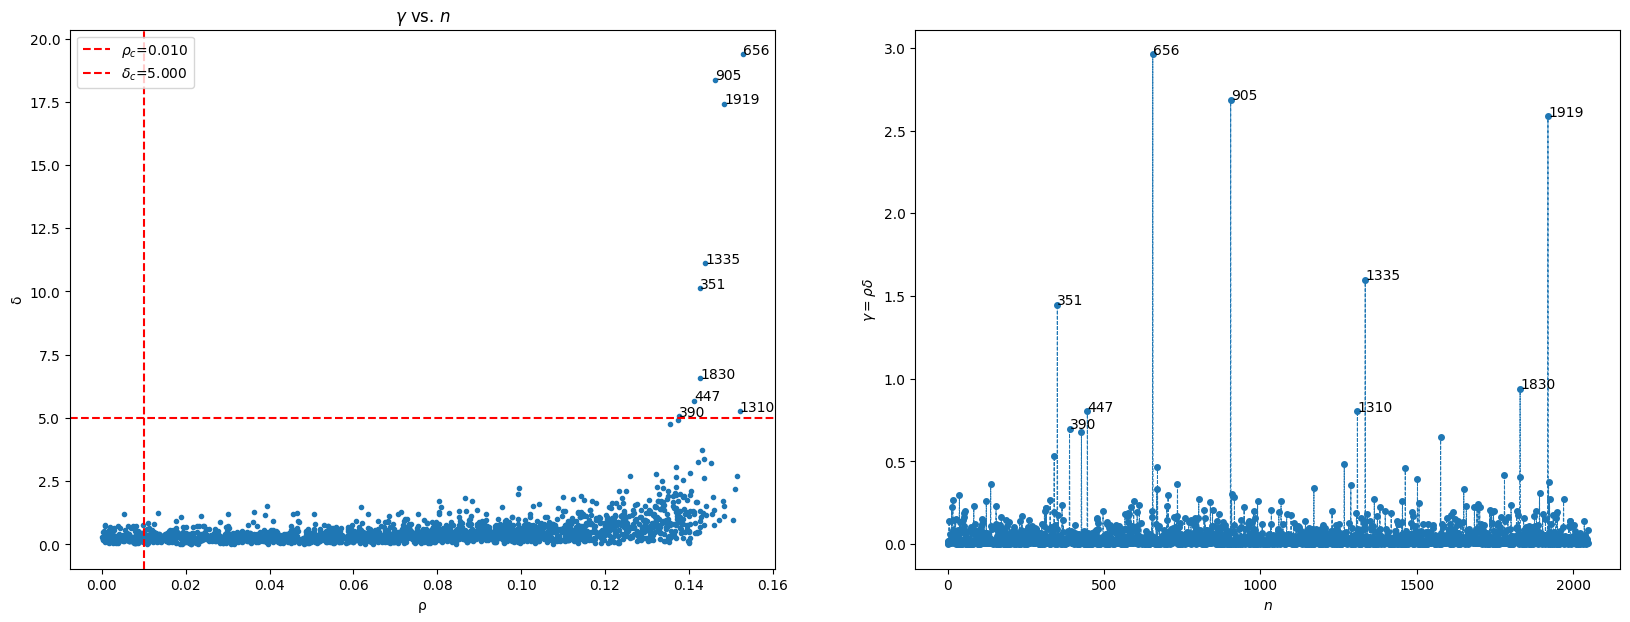

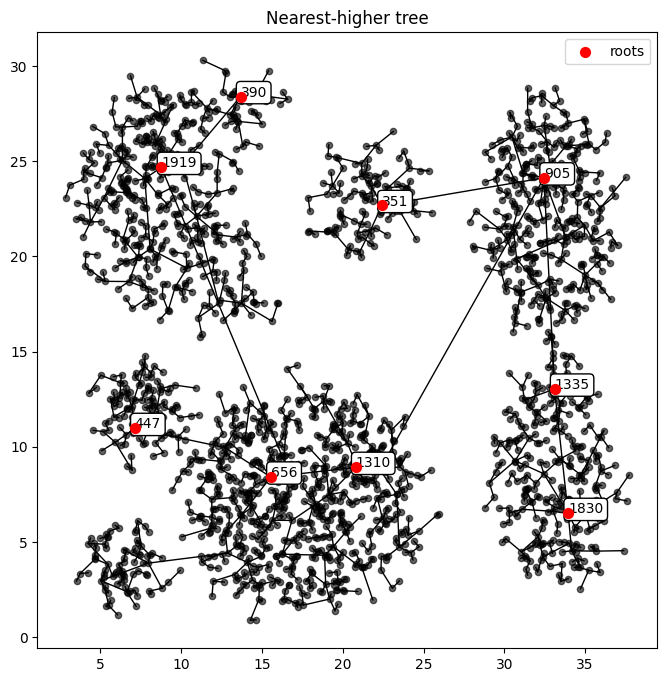

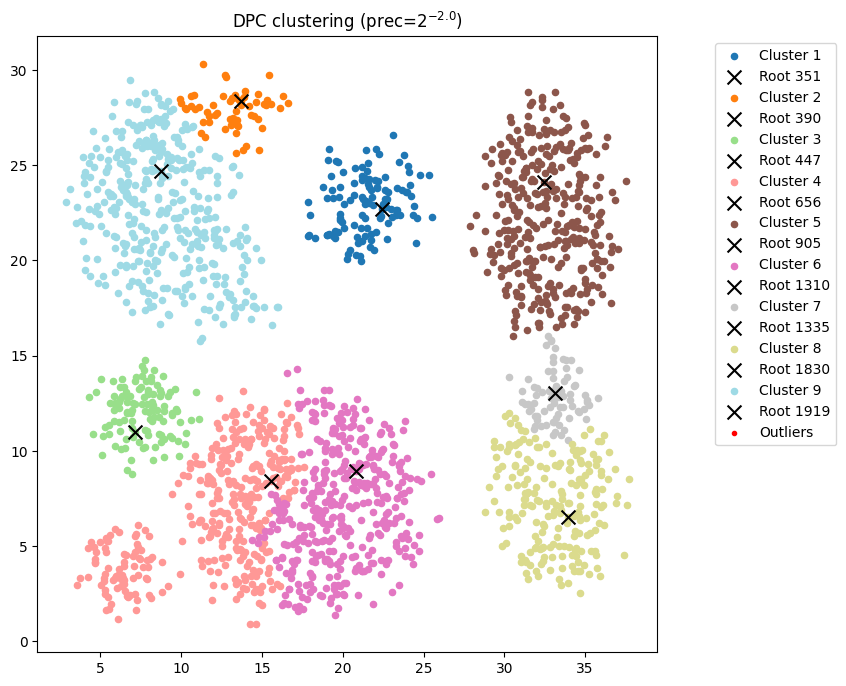

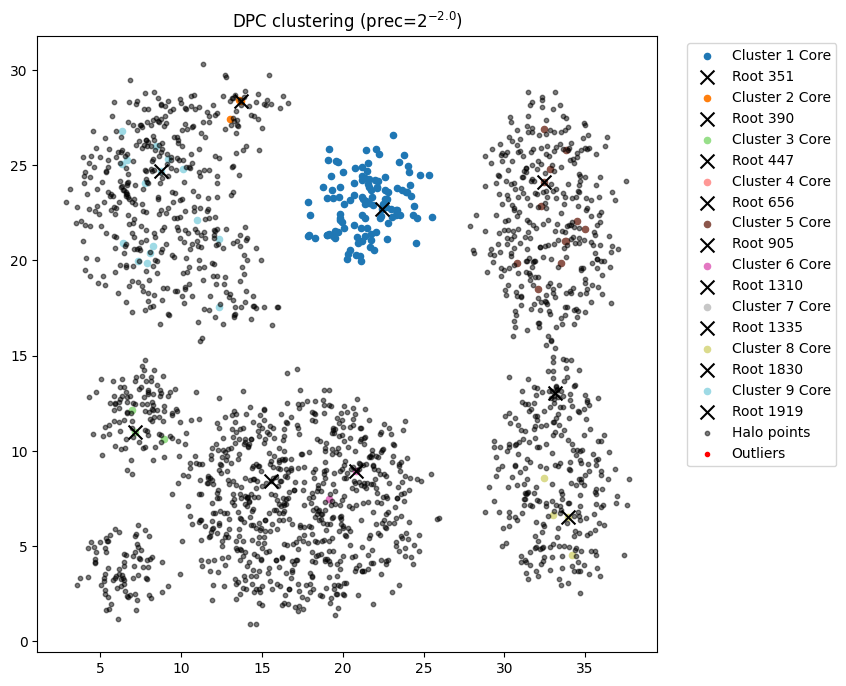

In [47]:
#Choose a synthetic dataset
dataset_name = 'Aggregation'  #["Compound", "Agreggation", "Spiral", "Flame", "R15", "2circles_noise", "banana", "2spiral", "Jain", "zelink1"]
mat = loadmat(r"C:/Users/gbs77/Desktop/Estudo/Investigação/DPC_worklab/datasets/{}.mat".format(dataset_name))
matrix_og = mat["data"]

#dataset generation parameters
N = 2**11 #number of elements in the new dataset
bandwidth = 0.7 #standard deviation for the gaussian kernel
random_state = 0 #random state for reproducibility

#DPC parameters
rho_c = 0.01 #density threshold
delta_c = 5.0 #nearest higher separation threshold
dc = 1.8 #standard deviation for the gaussian kernel

#generate dataset with the desired number of elements
matrix = expand_with_kde_keep_original(matrix_og, N,
                                       bandwidth=bandwidth,random_state=random_state)

#plot otiginal dataset and a circle of radius dc around a random point
from matplotlib.patches import Circle
plt.figure(figsize=[8,8])
plt.title('Original dataset')
plt.xlabel('x')
plt.ylabel('y')
plt.plot(matrix[:,0],matrix[:,1],'.',markersize=7)
plt.plot(matrix[1,0],matrix[1,1],'.',markersize=10,color='red')
ax = plt.gca() #get the current axes
circle = Circle((matrix[1,0], matrix[1,1]), radius=dc, fill=False, 
                color='red', linestyle='-',zorder=4)
ax.add_patch(circle) #add patch to the axes
plt.show()

#use the DPClustering class from dpc.py
dpc = DPClustering(matrix)

#set the desired precision
eps = 2**-2

#run DPC steps with time controllers
start = time.perf_counter()
dpc.gaussian_density(dc)
end = time.perf_counter()
print('densities time:', end-start)
    
start = time.perf_counter()
rhos = dpc.adjust_density_precision(prec=eps)
print(np.min(rhos),np.max(rhos))
end = time.perf_counter()
print('precision time:', end-start)
    
start = time.perf_counter()
nhs,deltas = dpc.nearest_highers()
#print(type(nhs),nhs.shape,nhs.dtype)
end = time.perf_counter()
print('neighbors time:', end-start)
    
start = time.perf_counter()
roots = dpc.find_roots(rho_c,delta_c)
clusters,outliers = dpc.fit(rho_c, delta_c, mark_outliers=False)
end = time.perf_counter()
print('clustering time:', end-start)
    
start = time.perf_counter()
roles = dpc.roles()
end = time.perf_counter()
print('roles time:', end-start)

dpc.plot_decision_graphs(rho_c, delta_c)
dpc.plot_tree()
dpc.plot_clusters() #without core and halo distincton
dpc.plot_clusters(plot_roles=True)
#show_DPC(matrix,delta_c=delta_c,rho_c=rho_c,dc=dc,prec=eps,out_bool=True,fig1=True,fig2=True)

## Clustering vs. Density Precision

All these studies are being done without considering outliers during the clustering process.

### Adjusted Rand Index ([ARI](https://en.wikipedia.org/wiki/Rand_index))

In [7]:
from sklearn.metrics import adjusted_rand_score

In [90]:
#Array with the number of elements N
Ns = 2**np.array([9,10,11,12,13,14,15])
#add mid points
Ns = np.sort(np.concatenate((Ns,Ns[:-1]*np.sqrt(2)))).astype(int)

#Array with precisions evaluated
precs = 2.0**np.linspace(-20,0,21,dtype=int)

#Array with the Adjusted Rand Index (ARI) for each (N, prec) pair (all points)
ARIs = np.zeros([len(Ns),len(precs)])
#Array with the Adjusted Rand Index (ARI) for each (N, prec) pair (core points)
ARIs_core = np.zeros([len(Ns),len(precs)])

#use the DPClustering class from dpc.py
from dpc import DPClustering

for n,N in enumerate(Ns):
    print(n, ' - N =', N)
    #Create the dataset with n elements
    data = expand_with_kde_keep_original(matrix_og, N, bandwidth=bandwidth,random_state=random_state)
    #Initiate the DPC
    dpc = DPClustering(data)
    #Compute the densities of each element (Gaussian kernel, cached)
    dpc.gaussian_density(dc)
    
    #Compute the ground truth (DPC with max precision)
    rhos_true = dpc.adjust_density_precision(prec=2**-64)
    nhs_true, deltas_true = dpc.nearest_highers()
    roots_true = dpc.find_roots(rho_c, delta_c)
    labels_true,outliers_true = dpc.fit(rho_c, delta_c, mark_outliers=False)
    roles_true = dpc.roles()
            
    for k,eps in enumerate(precs):
        #Preform the DPC with the same parameters for each precision
        rhos = dpc.adjust_density_precision(prec=eps)
        nhs, deltas = dpc.nearest_highers()
        roots = dpc.find_roots(rho_c, delta_c)
        labels, outliers = dpc.fit(rho_c, delta_c, mark_outliers=False)
               
        #Compute the ARI between the two clusterings
        ARIs[n,k] = adjusted_rand_score(labels_true, labels)
        
        #Compute the ARI between the two clusterings only considering core points
        #only consider the roles of the ground truth so the core points compared are the same
        ARIs_core[n,k] = adjusted_rand_score(labels_true[roles_true == 'core'], labels[roles_true == 'core'])
        

0  - N = 512
1  - N = 724
2  - N = 1024
3  - N = 1448
4  - N = 2048
5  - N = 2896
6  - N = 4096
7  - N = 5792
8  - N = 8192
9  - N = 11585
10  - N = 16384
11  - N = 23170
12  - N = 32768


In [ ]:
#Save data with ARI values
#np.savetxt('C:/Users/gbs77/Desktop/Estudo/Investigação/DPC_worklab/data/data_{}_ARI.txt'.format(dataset_name), ARIs)

#Save data with ARI values only with core points
#np.savetxt('C:/Users/gbs77/Desktop/Estudo/Investigação/DPC_worklab/data/data_{}_ARI_core.txt'.format(dataset_name), ARIs_core)

#### Average ARI over $N$ vs. precision, $\epsilon$

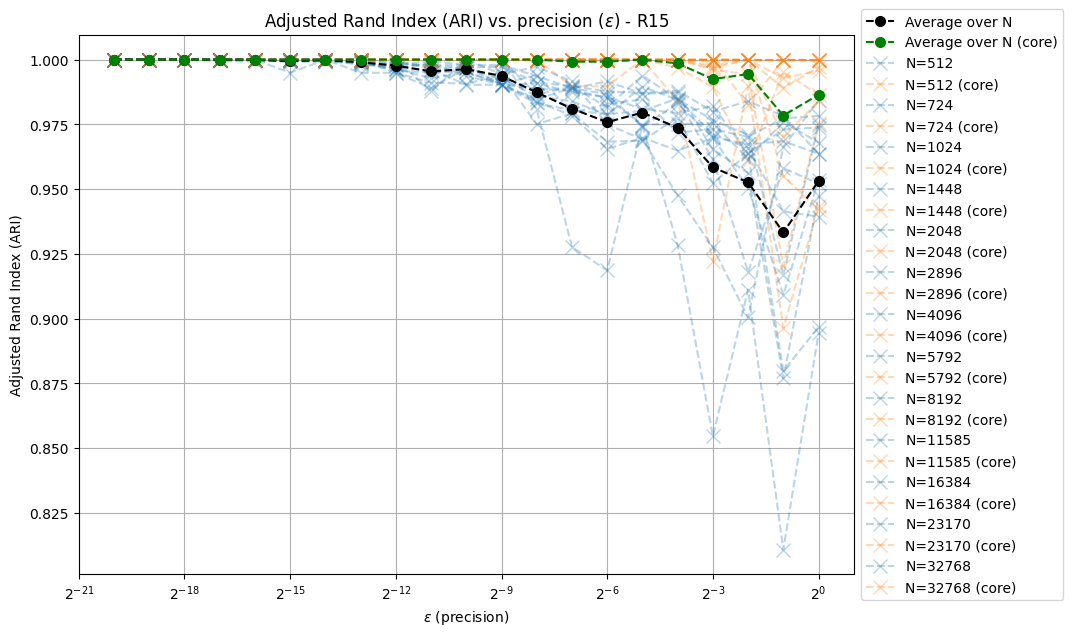

In [24]:
#import files
dataset_name= 'R15'
data_path = os.path.join("data", "data_{}_ARI.txt".format(dataset_name))
ARIs = np.loadtxt(data_path)
data_path = os.path.join("data", "data_{}_ARI_core.txt".format(dataset_name))
ARIs_core = np.loadtxt(data_path)  

#Array with the number of elements N
Ns = 2**np.array([9,10,11,12,13,14,15])
#add mid points
Ns = np.sort(np.concatenate((Ns,Ns[:-1]*np.sqrt(2)))).astype(int) 

#Array with precisions evaluated
precs = 2.0**np.linspace(-20,0,21,dtype=int)        

plt.figure(figsize=(10,7))  

ARIs_avg = np.mean(ARIs,axis=0)
plt.plot(precs,ARIs_avg,'--', color='black', marker='o',markersize=7,label='Average over N',zorder=4)

ARIs_core_avg = np.mean(ARIs_core,axis=0)
plt.plot(precs,ARIs_core_avg,'--', color='green', marker='o',markersize=7,label='Average over N (core)',zorder=4)

for i in range(len(Ns)):
    plt.plot(precs,ARIs[i,:],'--', marker='x',markersize=10,alpha=0.3,color='tab:blue',label='N={}'.format(Ns[i]))
    plt.plot(precs,ARIs_core[i,:],'--', marker='x',markersize=10,alpha=0.3,color='tab:orange',label='N={} (core)'.format(Ns[i]))
    

    
plt.title(r'Adjusted Rand Index (ARI) vs. precision $(\epsilon)$ - {}'.format(dataset_name))
plt.legend(bbox_to_anchor=(1, 0.5), loc='center left')
plt.xlabel(r'$\epsilon$ (precision)')
plt.ylabel('Adjusted Rand Index (ARI)')
plt.xscale('log', base=2)
plt.grid()
plt.show()

#### Critical precision, $\epsilon_{crit}$

Let's define the critical precision, $\epsilon_{crit}$, as the smallest value of $\epsilon$ (the greastest precision) such that ARI < $t$, where $t$ is a certain threshold to be defined ($0<t<1$). We can define the critical precision for different datasets tested and different numbers of elements composing the dataset, $N$ - for each dataset we will plot the critical precision as a function of the number of elements.

We will do this study including all dataset poins for evaluating ARI, and also including only the core points.

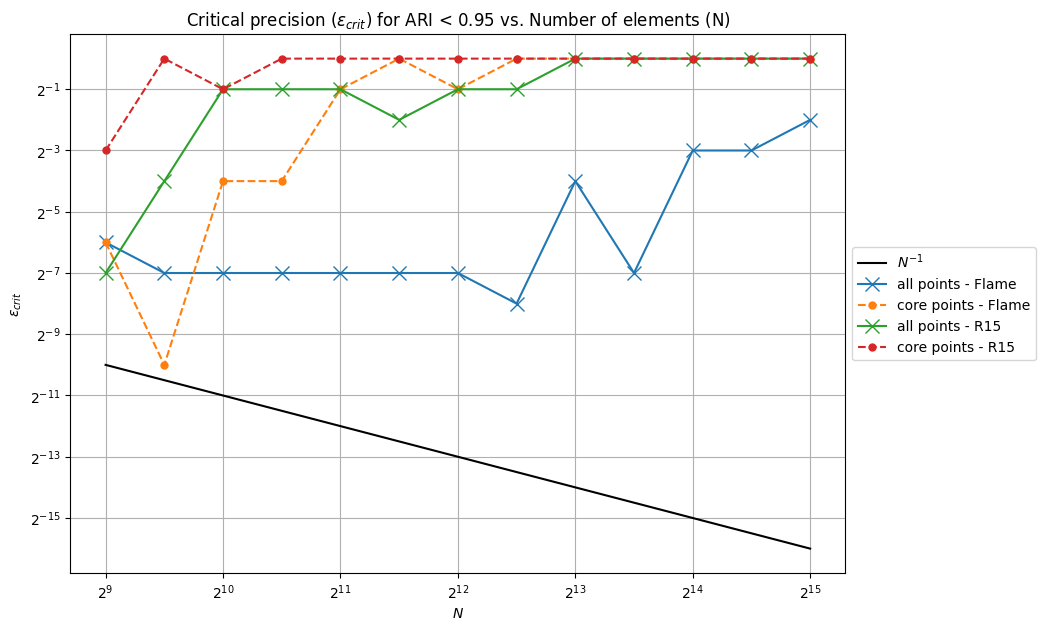

In [172]:
plt.figure(figsize=(10,7))

#define the ARI threshold to accept the clustering
t = 0.95

#plot referent line N vs 1/N
plt.plot(Ns,0.5/Ns**1,'-', color='k', label='$N^{-1}$')

#list with the datasets to be included in this study
datasets= ['Flame','R15']

for dataset in datasets:
    #import ARI data referring to a single dataset - including all points
    data_path = os.path.join("data", "data_{}_ARI.txt".format(dataset))
    ARIs_test = np.loadtxt(data_path)
    #import ARI data referring to a single dataset - including only core points
    data_path = os.path.join("data", "data_{}_ARI_core.txt".format(dataset))
    ARIs_core_test = np.loadtxt(data_path)
    
    #array to store the critical precisions
    crit_prec_ARI = np.zeros(len(Ns),dtype=float) #all points
    crit_prec_ARI_core = np.zeros(len(Ns),dtype=float) #core points
    
    for i,N in enumerate(Ns):
        i1 = np.where(ARIs_test[i,:] < t)[0]
        i2 = np.where(ARIs_core_test[i,:] < t)[0]
        
        if len(i1) != 0:
            crit_prec_ARI[i] = precs[i1[0]]
        else:   
            crit_prec_ARI[i] = precs[-1]
            
        if len(i2) != 0:
            crit_prec_ARI_core[i] = precs[i2[0]]
        else:   
            crit_prec_ARI_core[i] = precs[-1]
        
    plt.plot(Ns,crit_prec_ARI,'-', marker='x',markersize=10,label='all points - {}'.format(dataset))
    plt.plot(Ns,crit_prec_ARI_core,'--', marker='o',markersize=5,label='core points - {}'.format(dataset))
    

plt.title('Critical precision ($ε_{{crit}}$) for ARI < {} vs. Number of elements (N)'.format(t))
plt.legend(bbox_to_anchor=(1, 0.5), loc='center left')
plt.xlabel(r'$N$')
plt.ylabel(r'$ε_{crit}$')
plt.xscale('log', base=2)
plt.yscale('log', base=2)
plt.grid()

#Sabe the plot
#plt.savefig('C:/Users/gbs77/Desktop/Estudo/Investigação/DPC_worklab/plots/plot_crit_prec_ARI_095.png')

plt.show()

### Fraction of wrongly assigned elements

This is a least robust method to evaluate the quality of the clustering done with a chosen precision by directly comparing it with the clustering done with maximum precision (defined as ground truth). It consists of counting the number of elements wrongly assigned to a cluster relative to the assignment in the ground truth, i.e., elements that do not belong to the same cluster as they do in the ground truth. 

A wrongly assigned element is identified in the following simple way:
- localize to which cluster that element belongs to in the ground truth clustering, storing the cluster's root which we will name *true root*;
- check if the element being tested also belongs to the same cluster as the *true root* in the clustering being tested; 

The fraction of wrongly assigned elements as a function of the precision is calculated for different datasets and different number of elements, $N$. Due to the random nature in the computation of densities (since we are adjusting the precision by adding a random noise to the densities values) we preform a number *n_runs* (to be defined) of different runs, and then we can average the results of the number of runs.

In this study, we can also see which are the wrongly assigned elements, being expected that the majority of them are halo points. We will therefore store the fraction of halo points in the set of wrongly assigned elements for each experiment.

$\underline{\text{Note}}$: The identification of elements as halo points is done with the most precise clustering (ground truth), once the concepts (halo and core points), defined taking into account the density of each element, lose their original meaning when that density is computed with significantly less precision.

In [8]:
#Array with the number of elements N
Ns = 2**np.array([9,10,11,12,13,14,15])
#add mid points
Ns = np.sort(np.concatenate((Ns,Ns[:-1]*np.sqrt(2)))).astype(int)

#Array with precisions evaluated
precs = 2.0**np.linspace(-20,0,21,dtype=int)
n_precs = len(precs)

#Number of runs per dataset size
n_runs = 3

#Array with the fraction of wrongly assigned elements (all points)
fracs = np.zeros([len(Ns), n_runs * n_precs])
#Array with the fraction of wrongly assigned elements (core points)
fracs_core = np.zeros([len(Ns), n_runs * n_precs])

#Array to store the fraction of halo points between the wrongly assigned ones
fracs_halo = np.zeros([len(Ns), n_runs * n_precs])


for n,N in enumerate(Ns):
    print(n, ' - N =', N)
    #Create the dataset with N elements
    data = expand_with_kde_keep_original(matrix_og, N, bandwidth=bandwidth,random_state=random_state)
    #Initiate the DPC
    dpc = DPClustering(data)
    #Compute the densities of each element (Gaussian kernel, cached)
    dpc.gaussian_density(dc)

    #Compute the ground truth (DPC with max precision)
    rhos_true = dpc.adjust_density_precision(prec=2**-64)
    nhs_true, deltas_true = dpc.nearest_highers()
    roots_true = dpc.find_roots(rho_c, delta_c)
    labels_true, outliers_true = dpc.fit(rho_c, delta_c, mark_outliers=False)
    roles_true = dpc.roles()
    #Number of core points
    N_core = np.sum(roles_true == 'core')
    
    #associate each element with the root of the cluster to which it belongs (including the root itself)
    tree_true = np.ones(N) * -1 #-1 means not evaluated
    for root in roots_true:
        cluster = labels_true[root]
        elements = np.where(labels_true == cluster)
        tree_true[elements] = root
            
    for r in range(n_runs):
        print('run ',r)
        for k,eps in enumerate(precs):
            # Preform the DPC with the same parameters for each precision
            rhos = dpc.adjust_density_precision(prec=eps)
            nhs, deltas = dpc.nearest_highers()
            roots = dpc.find_roots(rho_c, delta_c)
            labels, outliers = dpc.fit(rho_c, delta_c, mark_outliers=False)
            
            #search for the true roots and then associate them with the elements of the cluster they belong to
            tree = np.ones(N) * -1 #-1 means not evaluated
            for root in roots_true:
                cluster = labels[root]
                elements = np.where(labels == cluster)
                tree[elements] = root
                   
            #Compute fraction of elements which were assigned to wrong cluster/root
            n_wrong = np.sum(tree != tree_true)
            fracs[n,k + n_precs*r] = n_wrong/N
            
            #Check how many of the wrongly assigned elements are halo points (according to the ground truth)
            if n_wrong != 0:
                fracs_halo[n,k + n_precs*r] = np.sum((tree != tree_true) & (roles_true == 'halo'))/n_wrong
                
            #Compute fraction of elements which were assigned to wrong cluster/root only considering core points 
            fracs_core[n,k + n_precs*r] = np.sum(tree[roles_true == 'core'] != tree_true[roles_true == 'core'])/N_core

0  - N = 512
run  0
run  1
run  2
1  - N = 724
run  0
run  1
run  2
2  - N = 1024
run  0
run  1
run  2
3  - N = 1448
run  0


KeyboardInterrupt: 

In [ ]:
#Save data with fractions values
#np.savetxt('C:/Users/gbs77/Desktop/Estudo/Investigação/DPC_worklab/data/data_{}_fracs.txt'.format(dataset_name), fracs)

#Save data with fractions values only with core points
#np.savetxt('C:/Users/gbs77/Desktop/Estudo/Investigação/DPC_worklab/data/data_{}_fracs_core.txt'.format(dataset_name), fracs_core)

#Save data with fractions of halo points
#np.savetxt('C:/Users/gbs77/Desktop/Estudo/Investigação/DPC_worklab/data/data_{}_fracs_halo.txt'.format(dataset_name), fracs_halo)

#### Average fraction averaged over $N$ and the number of runs vs. precision, $\epsilon$

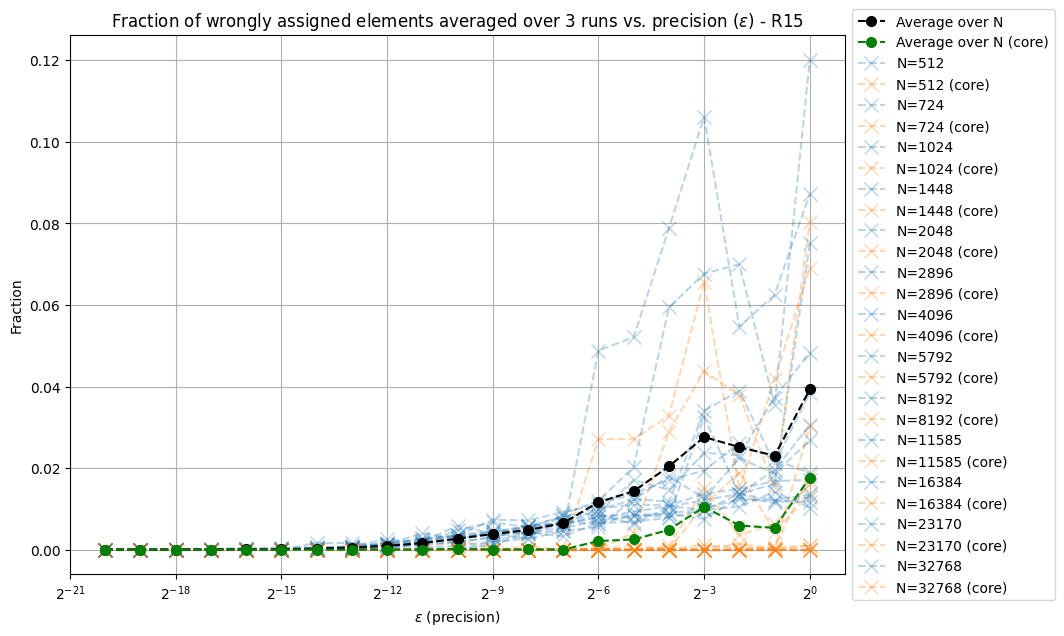

In [26]:
#import files
dataset_name='R15'
data_path = os.path.join("data", "data_{}_fracs.txt".format(dataset_name))
fracs = np.loadtxt(data_path)
data_path = os.path.join("data", "data_{}_fracs_core.txt".format(dataset_name))
fracs_core = np.loadtxt(data_path)  

#Array with the number of elements N
Ns = 2**np.array([9,10,11,12,13,14,15])
#add mid points
Ns = np.sort(np.concatenate((Ns,Ns[:-1]*np.sqrt(2)))).astype(int)

#Array with precisions evaluated
precs = 2.0**np.linspace(-20,0,21,dtype=int)
n_precs = len(precs)

#Number of runs per dataset size
n_runs = 3     

plt.figure(figsize=(10,7))  

#average over the number of runs
fracs_r = np.zeros([len(Ns),len(precs)])
fracs_r_core = np.zeros([len(Ns), len(precs)])
#cumulative average
for r in range(n_runs):
    fracs_r = (fracs_r * r + fracs[: , r*n_precs : (r+1)*n_precs])/(r+1)
    fracs_r_core = (fracs_r_core * r + fracs_core[ : , r*n_precs : (r+1)*n_precs])/(r+1)

fracs_avg = np.mean(fracs_r,axis=0)
plt.plot(precs,fracs_avg,'--', color='black', marker='o',markersize=7,label='Average over N',zorder=4)

fracs_core_avg = np.mean(fracs_r_core,axis=0)
plt.plot(precs,fracs_core_avg,'--', color='green', marker='o',markersize=7,label='Average over N (core)',zorder=4)

for i in range(len(Ns)):
    plt.plot(precs,fracs_r[i,:],'--', marker='x',markersize=10,alpha=0.3,color='tab:blue',label='N={}'.format(Ns[i]))
    plt.plot(precs,fracs_r_core[i,:],'--', marker='x',markersize=10,alpha=0.3,color='tab:orange',label='N={} (core)'.format(Ns[i]))
    

    
plt.title(r'Fraction of wrongly assigned elements averaged over {} runs vs. precision $(\epsilon)$ - {}'.format(n_runs, dataset_name))
plt.legend(bbox_to_anchor=(1, 0.5), loc='center left')
plt.xlabel(r'$\epsilon$ (precision)')
plt.ylabel('Fraction')
plt.xscale('log', base=2)
plt.grid()
plt.show()

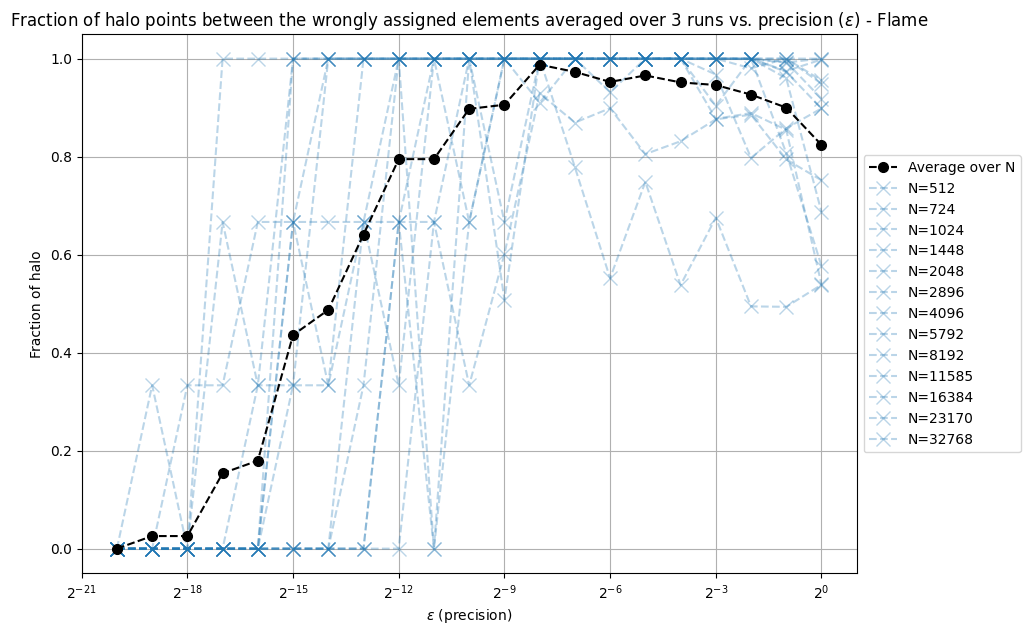

In [175]:
#import file
data_path = os.path.join("data", "data_{}_fracs_halo.txt".format(dataset_name))
fracs_halo = np.loadtxt(data_path)    

plt.figure(figsize=(10,7))  

#average over the number of runs
fracs_r_halo = np.zeros([len(Ns), len(precs)])

#cumulative average
for r in range(n_runs):
    fracs_r_halo = (fracs_r_halo * r + fracs_halo[: , r*n_precs : (r+1)*n_precs])/(r+1)

fracs_halo_avg = np.mean(fracs_r_halo,axis=0)
plt.plot(precs,fracs_halo_avg,'--', color='black', marker='o',markersize=7,label='Average over N',zorder=4)

for i in range(len(Ns)):
    plt.plot(precs,fracs_r_halo[i,:],'--', marker='x',markersize=10,alpha=0.3,color='tab:blue',label='N={}'.format(Ns[i]))
    
plt.title(r'Fraction of halo points between the wrongly assigned elements averaged over {} runs vs. precision $(\epsilon)$ - {}'.format(n_runs, dataset_name))
plt.legend(bbox_to_anchor=(1, 0.5), loc='center left')
plt.xlabel(r'$\epsilon$ (precision)')
plt.ylabel('Fraction of halo')
plt.xscale('log', base=2)
plt.grid()
plt.show()

#### Critical precision, $\epsilon_{crit}$

In this case, the critical precision is defined as the minimum value of $\epsilon$ (maximum precision) such that the fraction of wrongly assigned elements in the clustering is greater than $t$, where $t$ is a certain threshold to be defined ($0 < t < 1$). The fraction of wrongly assigned elements is the number of elements being evaluated (all or only core points) assigned to the wrong cluster relative to the ground truth, over the total number of elements being evaluated (all or only core points).

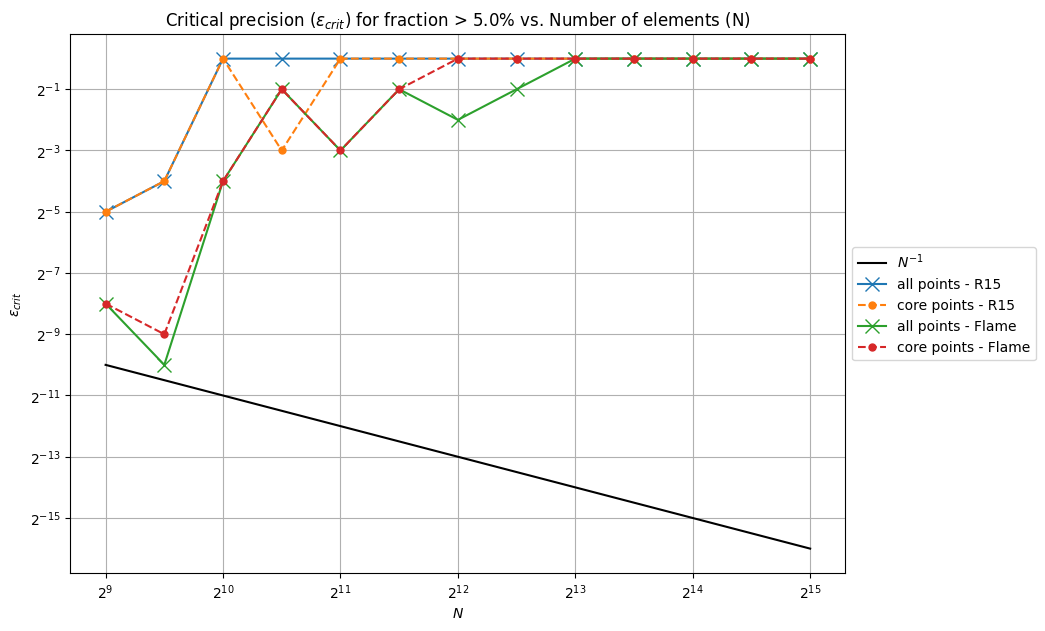

In [177]:
plt.figure(figsize=(10,7))

#define the fraction threshold to accept the clustering
t = 0.05

#plot referent line N vs 1/N
plt.plot(Ns,0.5/Ns**1,'-', color='k', label='$N^{-1}$')

#list with the datasets to be included in this study
datasets= ['R15', 'Flame']

for dataset in datasets:
    #import ARI data referring to a single dataset - including all points
    data_path = os.path.join("data", "data_{}_fracs.txt".format(dataset)) 
    fracs_test = np.loadtxt(data_path)
    #import ARI data referring to a single dataset - including only core points
    data_path = os.path.join("data", "data_{}_fracs_core.txt".format(dataset)) 
    fracs_core_test = np.loadtxt(data_path)
    
    #average over the number of runs
    fracs_r_test = np.zeros([len(Ns),len(precs)])
    fracs_r_core_test = np.zeros([len(Ns), len(precs)])
    #cumulative average
    for r in range(n_runs):
        fracs_r_test = (fracs_r_test * r + fracs_test[: , r*n_precs : (r+1)*n_precs])/(r+1)
        fracs_r_core_test = fracs_r_core_test * r + fracs_core_test[ : , r*n_precs : (r+1)*n_precs]/(r+1)
    
    #array to store the critical precisions
    crit_prec_fracs = np.zeros(len(Ns),dtype=float) #all points
    crit_prec_fracs_core = np.zeros(len(Ns),dtype=float) #core points
    
    for i,N in enumerate(Ns):
        i1 = np.where(fracs_r_test[i,:] > t)[0]
        i2 = np.where(fracs_r_core_test[i,:] > t)[0]
        
        if len(i1) != 0:
            crit_prec_fracs[i] = precs[i1[0]]
        else:   
            crit_prec_fracs[i] = precs[-1]
            
        if len(i2) != 0:
            crit_prec_fracs_core[i] = precs[i2[0]]
        else:   
            crit_prec_fracs_core[i] = precs[-1]
        
    plt.plot(Ns,crit_prec_fracs,'-', marker='x',markersize=10,label='all points - {}'.format(dataset))
    plt.plot(Ns,crit_prec_fracs_core,'--', marker='o',markersize=5,label='core points - {}'.format(dataset))
    

plt.title('Critical precision ($ε_{{crit}}$) for fraction > {}% vs. Number of elements (N)'.format(t*100))
plt.legend(bbox_to_anchor=(1, 0.5), loc='center left')
plt.xlabel(r'$N$')
plt.ylabel(r'$ε_{crit}$')
plt.xscale('log', base=2)
plt.yscale('log', base=2)
plt.grid()

#Sabe the plot
#plt.savefig('C:/Users/gbs77/Desktop/Estudo/Investigação/DPC_worklab/plots/plot_crit_prec_fracs_1.png')

plt.show()

#### Visual perspective: Are the wrongly assigned elements halo points?

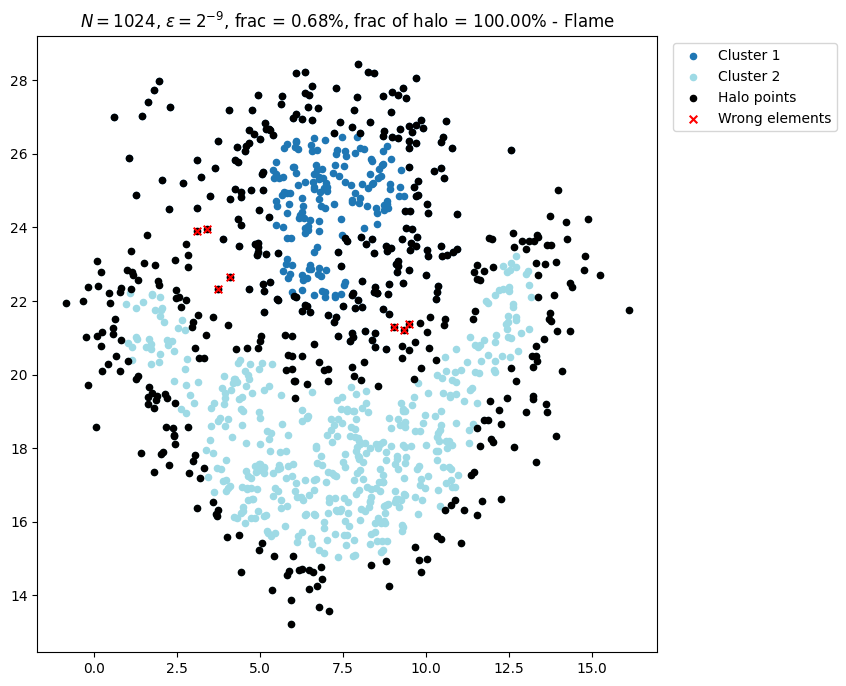

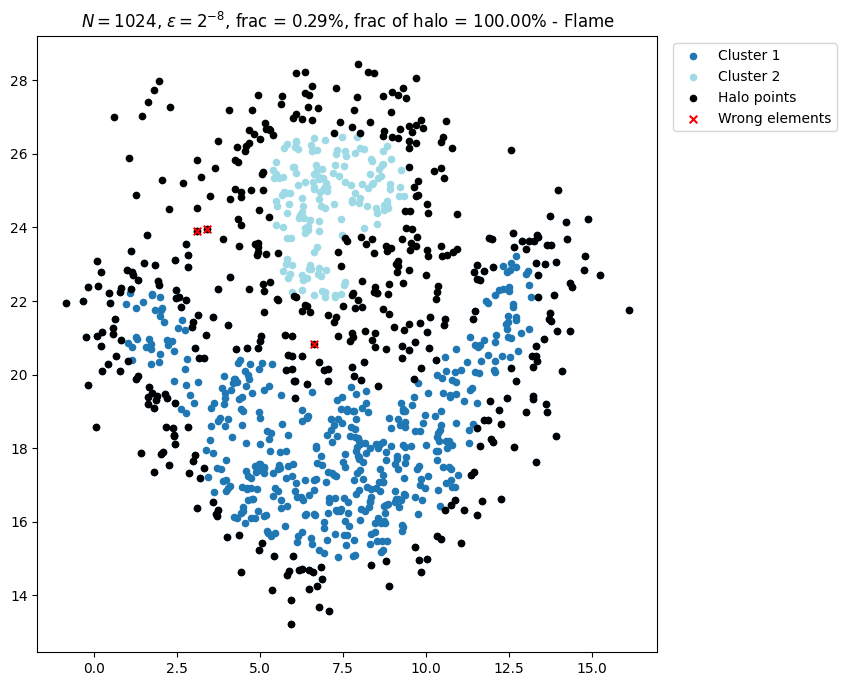

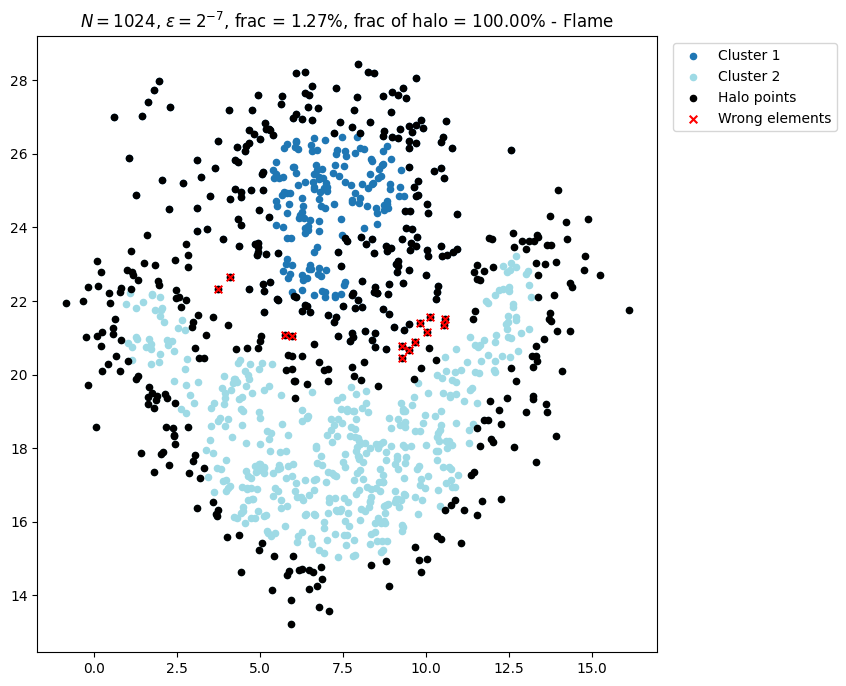

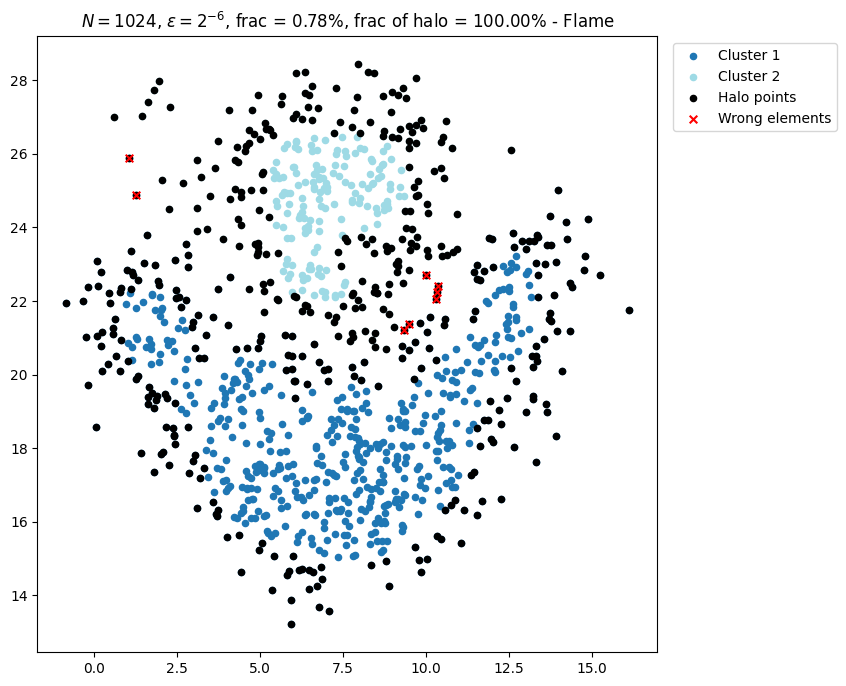

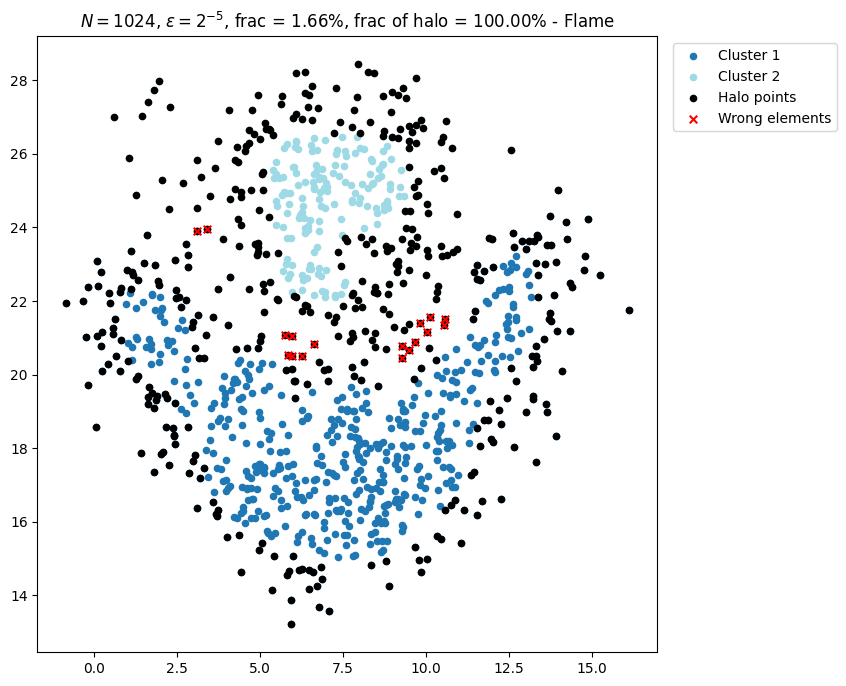

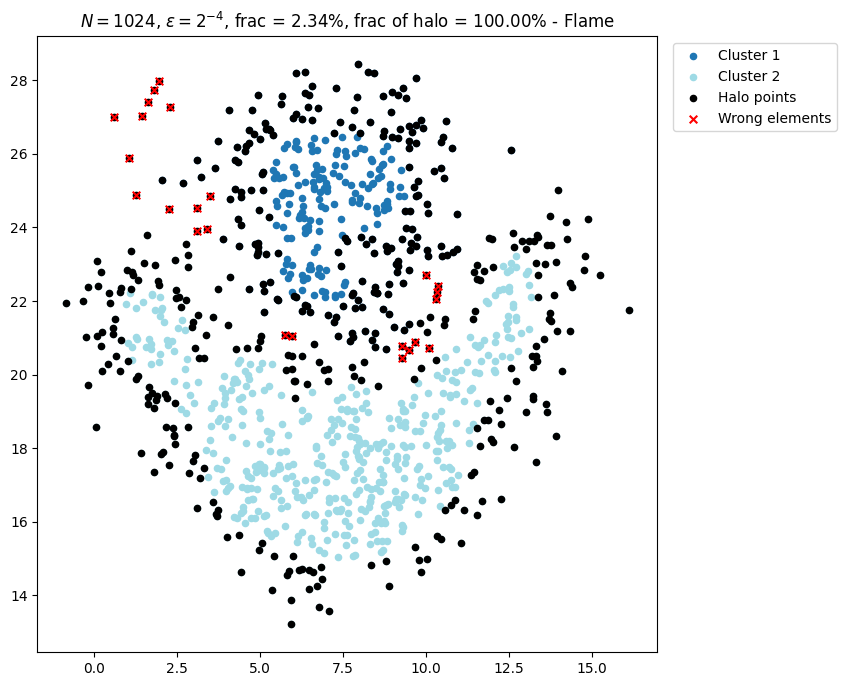

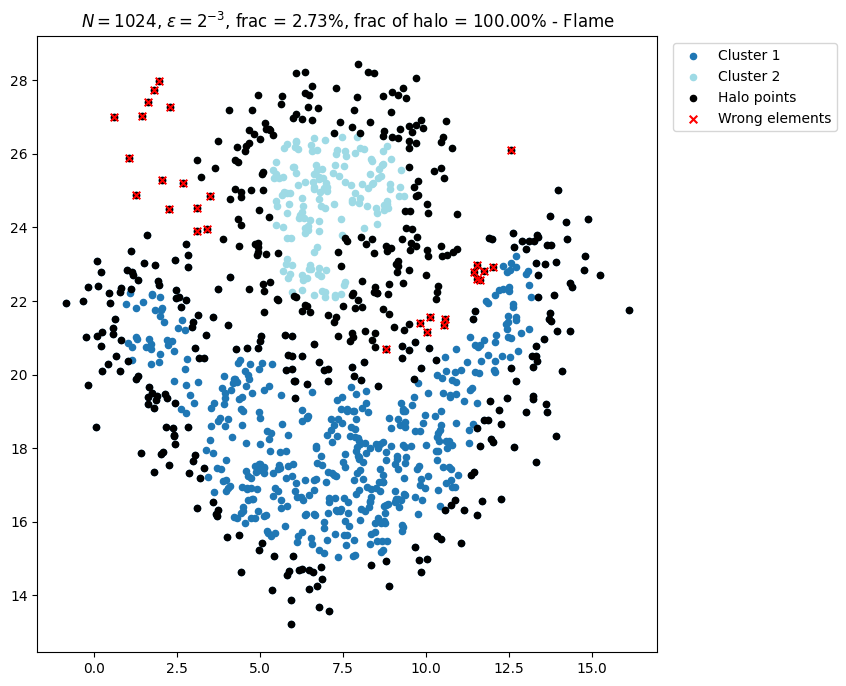

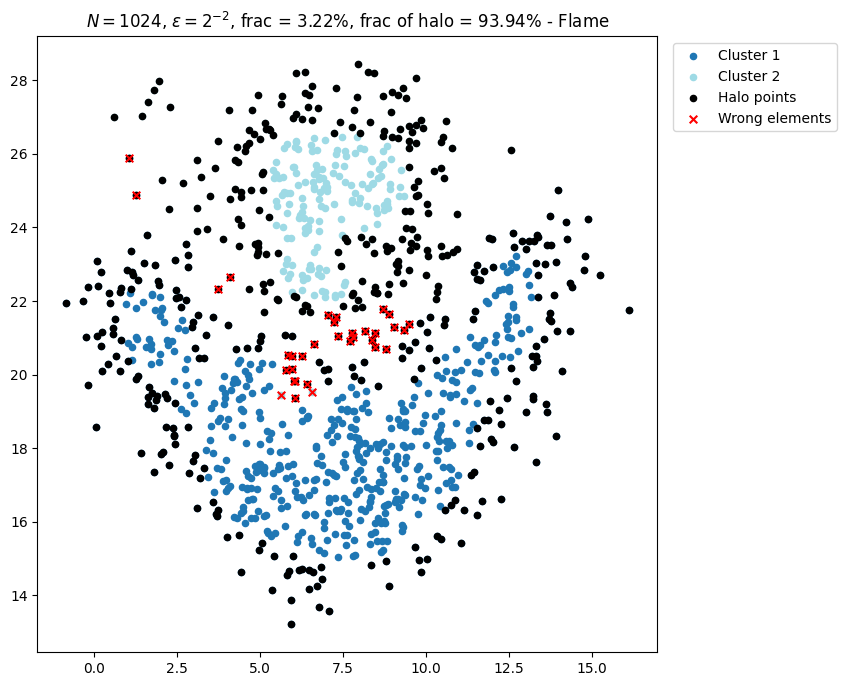

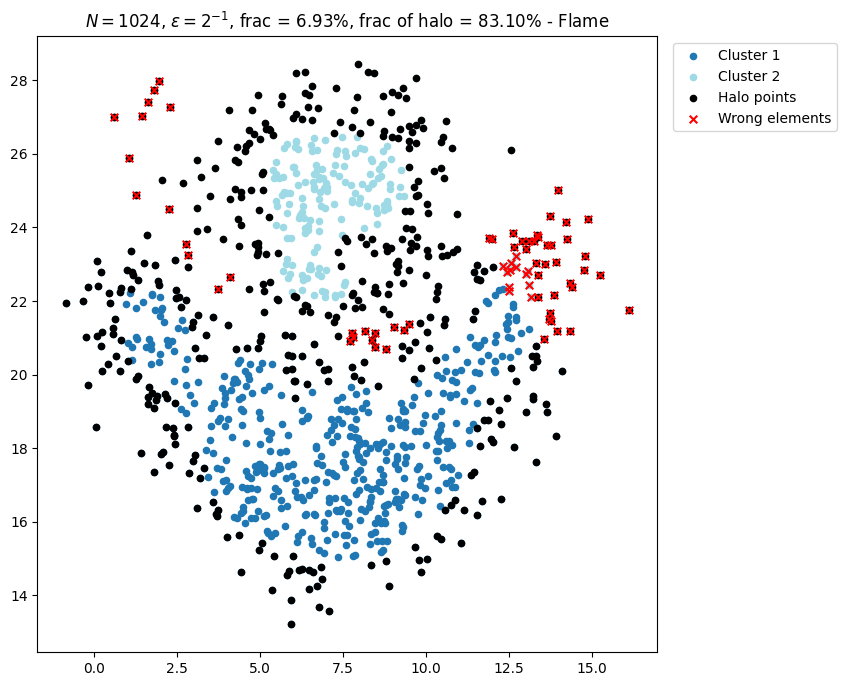

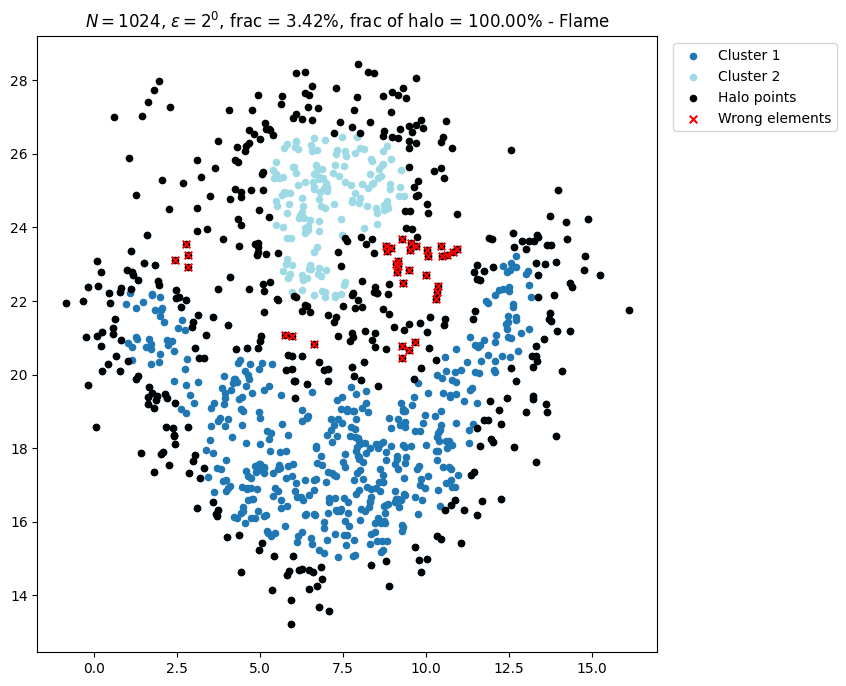

In [10]:
#Number of elements in the dataset
N = 2**10

#Array with precisions evaluated
precs_2 = 2.0**np.linspace(-15,0,16,dtype=int)

#Create the dataset with N elements
data = expand_with_kde_keep_original(matrix_og, N, bandwidth=bandwidth,random_state=random_state)
#Initiate the DPC
dpc = DPClustering(data)
#Compute the densities of each element (Gaussian kernel, cached)
dpc.gaussian_density(dc)
#Compute the ground truth (DPC with max precision)
rhos_true = dpc.adjust_density_precision(prec=2**-64)
nhs_true, deltas_true = dpc.nearest_highers()
roots_true = dpc.find_roots(rho_c, delta_c)
labels_true, outliers_true = dpc.fit(rho_c, delta_c, mark_outliers=False)
roles_true = dpc.roles()
#Number of core points
N_core = np.sum(roles_true == 'core')

#associate each element with the root of the cluster to which it belongs (including the root itself)
tree_true = np.ones(N) * -1 #-1 means not evaluated
for root in roots_true:
    cluster = labels_true[root]
    elements = np.where(labels_true == cluster)
    tree_true[elements] = root
        
for k,eps in enumerate(precs_2):
    #Preform the DPC with the same parameters for each precision
    rhos = dpc.adjust_density_precision(prec=eps)
    nhs, deltas = dpc.nearest_highers()
    roots = dpc.find_roots(rho_c, delta_c)
    labels, outliers = dpc.fit(rho_c, delta_c, mark_outliers=False)
    
    #Search for the true roots and then associate them with the elements of the cluster they belong to
    tree = np.ones(N) * -1 #-1 means not evaluated
    for root in roots_true:
        cluster = labels[root]
        elements = np.where(labels == cluster)
        tree[elements] = root
            
    #Compute fraction of elements which were assigned to wrong cluster/root
    wrong = np.where(tree != tree_true)[0]
    n_wrong = len(wrong)
    if n_wrong != 0:
        frac = n_wrong / N
        frac_halo = np.sum((tree != tree_true) & (roles_true == 'halo')) / n_wrong
        
        #Plot the clusters, the halo points and the wrongly assigned elements
        plt.figure(figsize=(8, 8))
        plt.title(r'$N = {}$, $\epsilon = 2^{{{}}}$, frac = {:.2f}%, frac of halo = {:.2f}% - {}'.format(N,int(np.log2(eps)),frac * 100,frac_halo * 100, dataset_name))
        cmap = plt.colormaps["tab20"].resampled(len(roots))
        halo_points = np.where(roles_true == 'halo')[0]
        for cid, root in enumerate(roots):
            cluster_points = np.where(labels == cid)[0]
            plt.scatter(data[cluster_points, 0], data[cluster_points, 1], color=cmap(cid), label=f'Cluster {cid+1}',s=20)
            
        plt.scatter(data[halo_points, 0], data[halo_points, 1], color='black', label=f'Halo points',s=20)
        plt.scatter(data[wrong, 0], data[wrong, 1], color='red', marker='x' ,label=f'Wrong elements',s=30)
        plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
        plt.show()


### DPC with random densities?

#### Density Countour map

In [8]:
from scipy.interpolate import griddata
import numpy.ma as ma
from scipy.ndimage import gaussian_filter



def density_grid_2d(dataset, densities):
    '''
    Function that creates a grid with density values over the 2-dimensional dataset space,
    using interpolation from scipy
    
    Inputs:
        - dataset: np.ndarray, array of shape (N,2) with the position of the dataset elements;
        - densities: np.ndarray, array of shape (,N) with the densities of the dataset elements;
    Outpus:
        - grid_x: np.ndarray, array storing the horizontal coordinates where the densities where computed;
        - grid_y: np.ndarray, array storing the vertical coordinates where the densities where computed;
        - grid_rho: np.ndarray, array storint the density values;
    '''
    #Number of elements
    N=len(densities)
    #Create a regular grid to interpolate onto
    grid_x, grid_y = np.meshgrid(
        np.linspace(min(dataset[:,0]), max(dataset[:,0]), 800),
        np.linspace(min(dataset[:,1]), max(dataset[:,1]), 800)
    )

    #Interpolate using cubic method
    grid_rho = griddata(points=dataset, values=densities, xi=(grid_x, grid_y), method='cubic')
    
    #grid_rho = ma.masked_invalid(grid_rho)
    #grid_rho = gaussian_filter(grid_rho, sigma=2)
    
    return grid_x, grid_y, grid_rho

0.527915312363849 7.224447752585202e-06


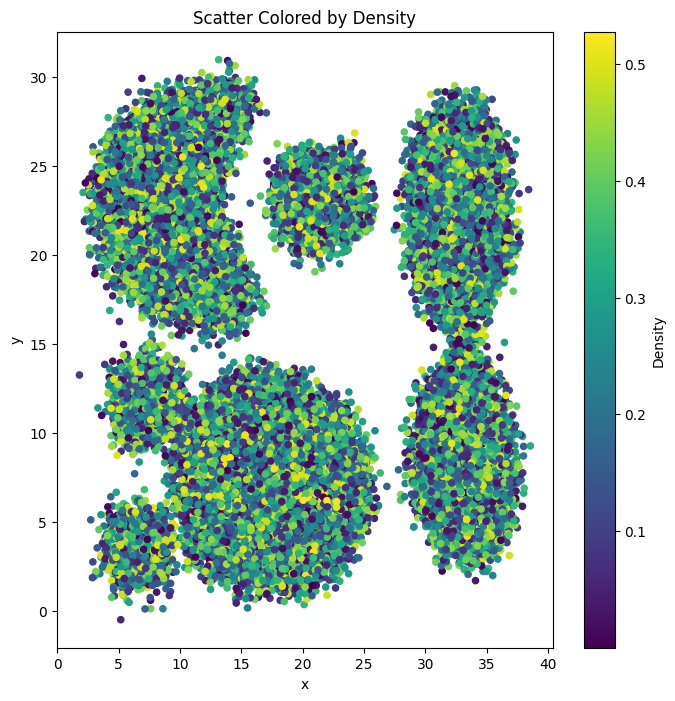

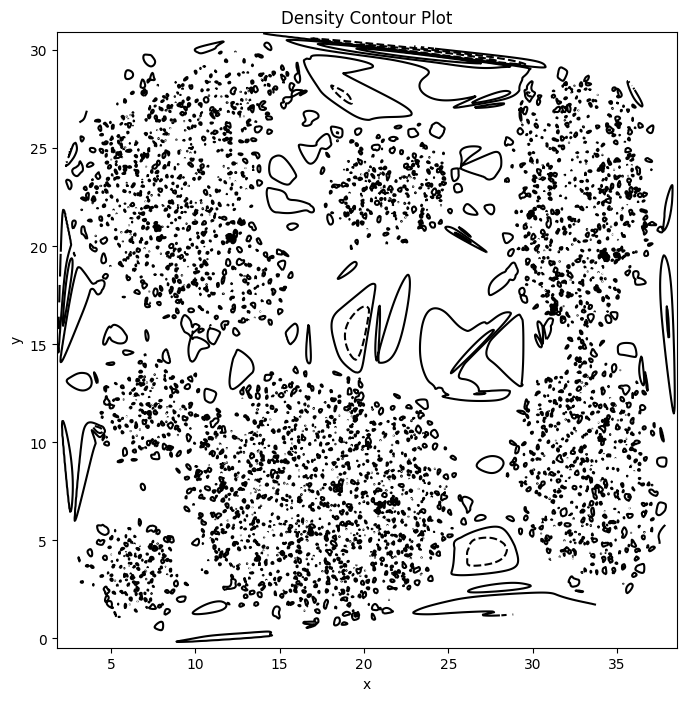

In [30]:
#Choose a synthetic dataset
dataset_name = 'Aggregation'  #["Compound", "Agreggation", "Spiral", "Flame", "R15", "2circles_noise", "banana", "2spiral", "Jain", "zelink1"]
mat = loadmat(r"C:/Users/gbs77/Desktop/Estudo/Investigação/DPC_worklab/datasets/{}.mat".format(dataset_name))
matrix_og = mat["data"]

#dataset generation parameters
N = 2**15 #number of elements in the new dataset
bandwidth = 0.7 #standard deviation for the gaussian kernel
random_state = 0 #random state for reproducibility

#DPC parameters
rho_c = 0.01 #density threshold
delta_c = 5.0 #nearest higher separation threshold
dc = 1.8 #standard deviation for the gaussian kernel

#generate dataset with the desired number of elements
matrix = expand_with_kde_keep_original(matrix_og, N, bandwidth=bandwidth,random_state=random_state)

#initialize dpc
dpc = DPClustering(matrix)

#define the desired precision
eps = 2**0

#compute densities
dpc.gaussian_density(dc)
#adjuste the density values with the desired precision
rhos = dpc.adjust_density_precision(prec=eps)
#rhos = dpc.random_density()
print(np.max(rhos),np.min(rhos))

#plot the density map with dataset points
fig, ax = plt.subplots(figsize=(8,8))
sc = ax.scatter(matrix[:,0], matrix[:,1], c=rhos, cmap="viridis", s=20)
plt.colorbar(sc, label="Density")
plt.title("Scatter Colored by Density")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

#create the density grid
X,Y,RHOS = density_grid_2d(matrix,rhos)

#plot the density grid as a contour map
fig, ax = plt.subplots(figsize=(8,8))
#number of curves
n_curves=50
CS1 = ax.contour(X,Y,RHOS,colors='black',levels=n_curves)
contour1 = plt.Line2D([0], [0], color='black', linestyle='solid', label=r'$\delta = 2^{{{}}}$'.format(int(np.log2(eps))))
plt.title("Density Contour Plot")
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#plot the density grid as a color map
# fig, ax = plt.subplots(figsize=(8,8))
# plt.imshow(RHOS[::-1])
# plt.colorbar()
# plt.title("Density Color Map")
# plt.xlabel('x')
# plt.ylabel('y')
# plt.show()

#### DPC based on Random Uniform Densities - Is it possible?

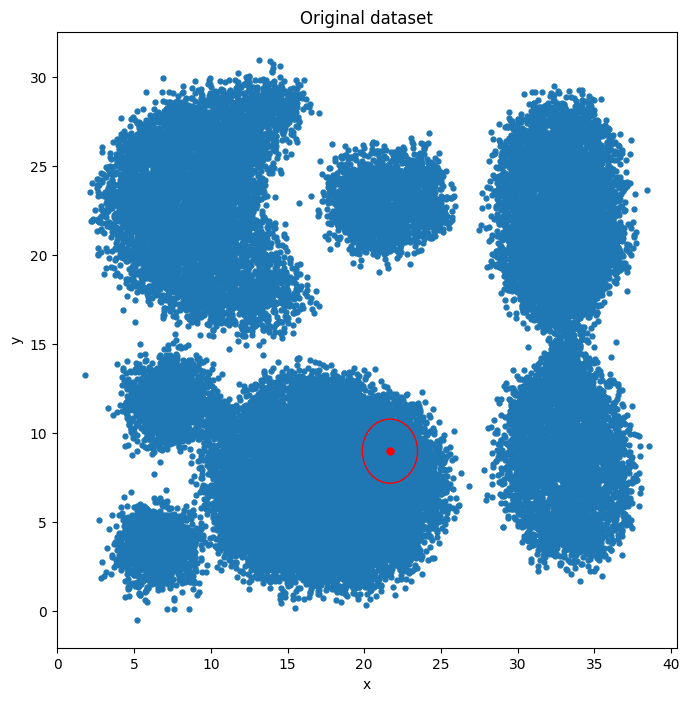

1.8698024783603273e-05 0.9999341751024461


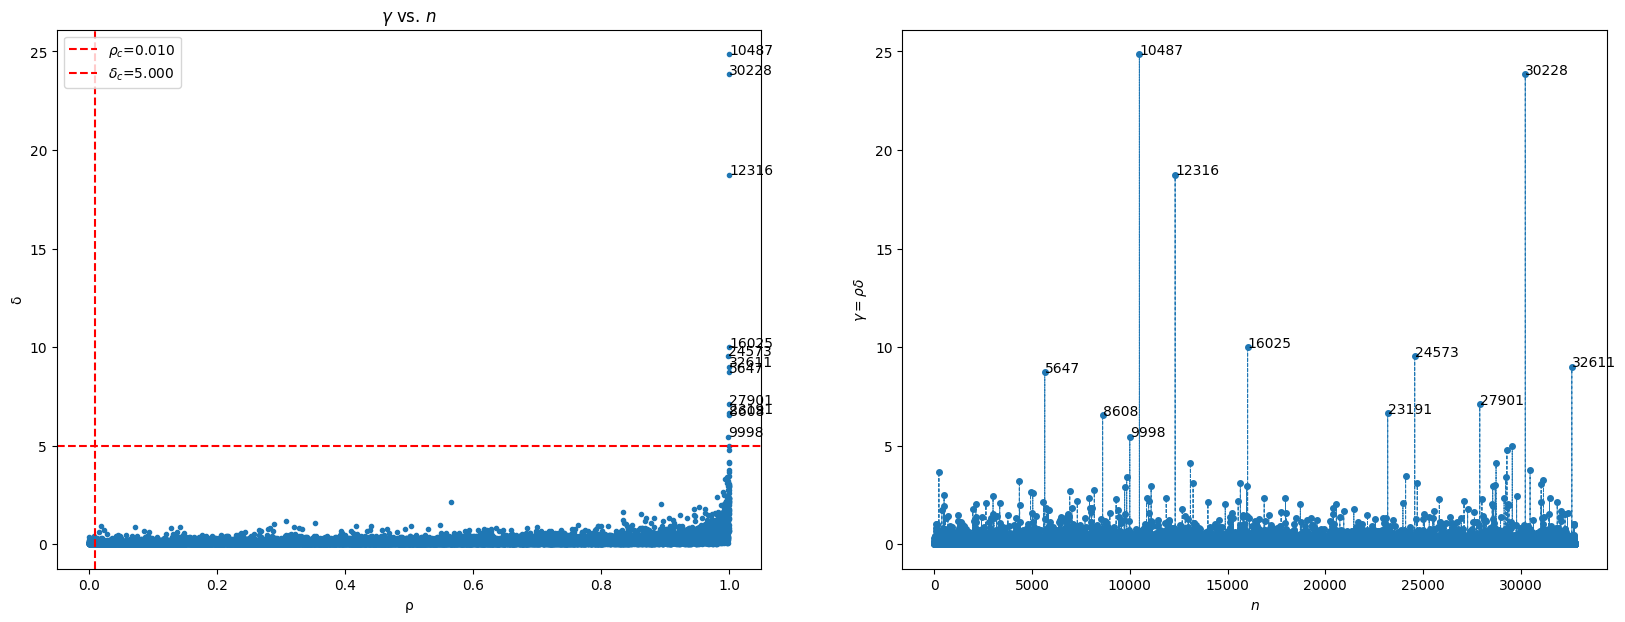

c:\Users\gbs77\anaconda3\envs\quant_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


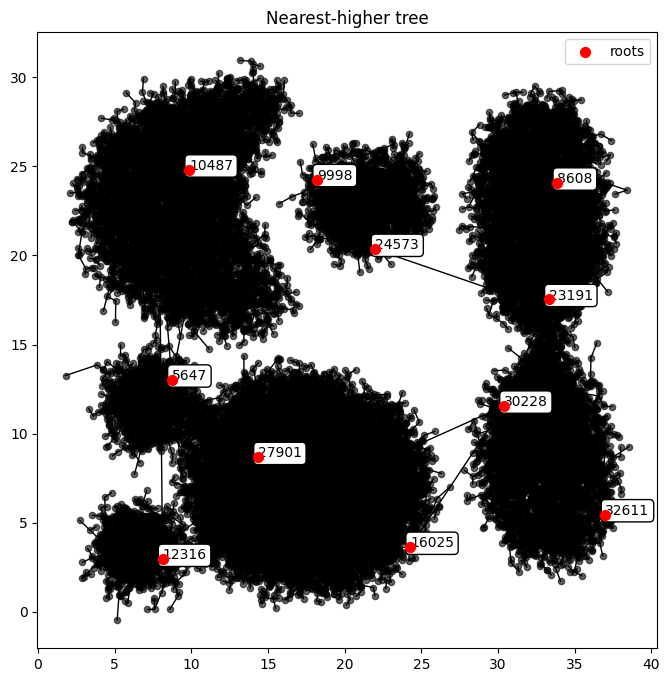

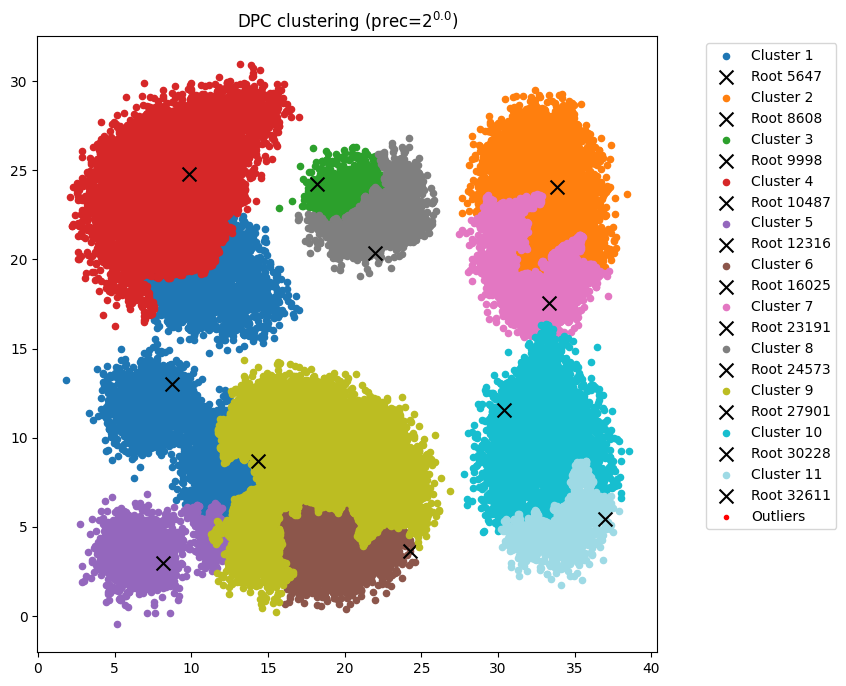

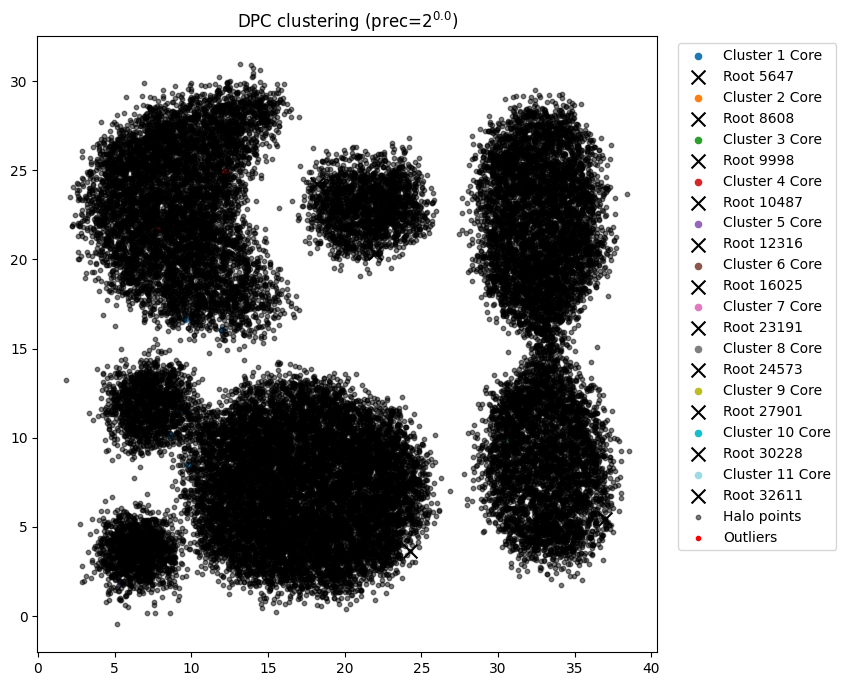

In [36]:
#Choose a synthetic dataset
dataset_name = 'Aggregation'  #["Compound", "Agreggation", "Spiral", "Flame", "R15", "2circles_noise", "banana", "2spiral", "Jain", "zelink1"]
mat = loadmat(r"C:/Users/gbs77/Desktop/Estudo/Investigação/DPC_worklab/datasets/{}.mat".format(dataset_name))
matrix_og = mat["data"]

#dataset generation parameters
N = 2**15 #number of elements in the new dataset
bandwidth = 0.7 #standard deviation for the gaussian kernel
random_state = 0 #random state for reproducibility

#DPC parameters
rho_c = 0.01 #density threshold
delta_c = 5.0 #nearest higher separation threshold
dc = 1.8 #standard deviation for the gaussian kernel

#generate dataset with the desired number of elements
matrix = expand_with_kde_keep_original(matrix_og, N, bandwidth=bandwidth,random_state=random_state)

#initialize dpc
dpc = DPClustering(matrix)

#define the desired precision
eps = 2**0

#plot otiginal dataset and a circle of radius dc around a random point
from matplotlib.patches import Circle
plt.figure(figsize=[8,8])
plt.title('Original dataset')
plt.xlabel('x')
plt.ylabel('y')
plt.plot(matrix[:,0],matrix[:,1],'.',markersize=7)
plt.plot(matrix[1,0],matrix[1,1],'.',markersize=10,color='red')
ax = plt.gca() #get the current axes
circle = Circle((matrix[1,0], matrix[1,1]), radius=dc, fill=False, 
                color='red', linestyle='-',zorder=4)
ax.add_patch(circle) #add patch to the axes
plt.show()

#use the DPClustering class from dpc.py
from dpc import DPClustering
dpc = DPClustering(matrix)

#run DPC steps
dpc.gaussian_density(dc)
rhos = dpc.adjust_density_precision(prec=eps)
rhos = dpc.random_density() #generate random densities between 0 and 1
print(np.min(rhos),np.max(rhos))
nhs,deltas = dpc.nearest_highers()
roots = dpc.find_roots(rho_c,delta_c)
clusters,outliers = dpc.fit(rho_c, delta_c, mark_outliers=False)
roles = dpc.roles()
dpc.plot_decision_graphs(rho_c, delta_c)
dpc.plot_tree()
dpc.plot_clusters() #without core and halo distincton
dpc.plot_clusters(plot_roles=True)
#show_DPC(matrix,delta_c=delta_c,rho_c=rho_c,dc=dc,prec=eps,out_bool=True,fig1=True,fig2=True)